In [31]:
import numpy as np#
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict

cmaps = OrderedDict()
cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

In [3]:
amps = np.arange(0.01,1.5,.01)
tot_L = 10
ells = range(1,tot_L)
ps = np.zeros((tot_L, len(amps)))
for indL in ells:
    for inda, a in enumerate(amps):
        ps[indL, inda] = np.load("/data/uab-giq/scratch/matias/dynamo/{}/{}/Ps.npy".format(indL,np.round(a,3)))[0, 100]

In [27]:
#tot_L = 10
#ells = range(1,tot_L)
pss = np.zeros((3, len(amps)))
for ii,indL in enumerate([10,20,30]):
    for inda, a in enumerate(amps):
        try:
            pss[ii, inda] = np.load("/data/uab-giq/scratch/matias/dynamo/{}/{}/Ps.npy".format(indL,np.round(a,3)))[0, 100]
        except Exception:
            pss[ii, inda] = pss[ii, inda-1]
                

In [4]:
def hel(alpha):
    return (1+np.sqrt(1-np.exp(-4*alpha**2)))/2

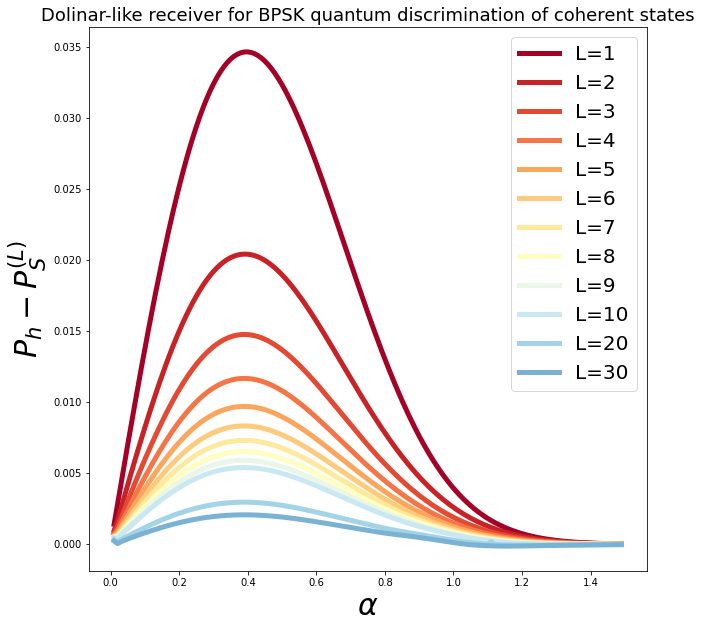

In [55]:
name = "RdYlBu"
cc=cm.get_cmap(name)
plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)
lw=5
colors = {0:"red",1:"blue",2:"pink",3:"black"}
ind=0
tot=14
for layer in range(1,10):
    ax1.plot(amps,hel(amps) - 1 + ps[layer], label="L="+str(layer), linewidth=lw, color=cc(ind/tot))# color=colors[layer])
    ind+=1
for indl, lay in enumerate([10,20,30]):
    ax1.plot(amps, hel(amps)-1+pss[indl], label="L="+str(lay),linewidth=lw, color=cc(ind/tot))
    ind+=1
#plt.plot(amps,1-hel(amps),'--')
ax1.legend(prop={"size":20})
ax1.set_xlabel(r'$\alpha$',size=30)
ax1.set_ylabel(r'$P_h - P_S^{(L)}$',size=30)
ax1.set_title("Dolinar-like receiver for BPSK quantum discrimination of coherent states",size=18)

plt.savefig("bpsk_noiseless.pdf")